# DepthAI - Face Detection

This notebook will read and display frames from the rgb camera and a face detecting neural network.

In [1]:
from pathlib import Path
import cv2
import depthai
import numpy as np

In [2]:
# these modules will enable us to build a simple event driven UI in the Jupyter notebook
import ipywidgets as widgets
import threading
from IPython.display import display, Image

In [3]:
pipeline = depthai.Pipeline()

In [4]:
cam_rgb = pipeline.createColorCamera()
cam_rgb.setPreviewSize(300, 300)
cam_rgb.setInterleaved(False)

In [5]:
detection_nn = pipeline.createMobileNetDetectionNetwork()
blobPath = str(Path('./face-detection-retail-0004.blob').resolve().absolute())
print("blobPath =",blobPath)
detection_nn.setBlobPath(blobPath)
detection_nn.setConfidenceThreshold(0.5)
cam_rgb.preview.link(detection_nn.input)

xout_rgb = pipeline.createXLinkOut()
xout_rgb.setStreamName("rgb")
cam_rgb.preview.link(xout_rgb.input)

xout_nn = pipeline.createXLinkOut()
xout_nn.setStreamName("nn")
detection_nn.out.link(xout_nn.input)

blobPath = C:\Users\alfre\src\jupyter\depthai\2-face-detection-retail\face-detection-retail-0004.blob


In [8]:
# Pipeline is now finished, and we need to find an available device to run our pipeline
# we are using context manager here that will dispose the device after we stop using it
def showVideo(button):
    with depthai.Device(pipeline) as device:
        q_rgb = device.getOutputQueue("rgb")
        q_nn = device.getOutputQueue("nn")

        frame = None
        detections = []

        def frameNorm(frame, bbox):
            normVals = np.full(len(bbox), frame.shape[0])
            normVals[::2] = frame.shape[1]
            return (np.clip(np.array(bbox), 0, 1) * normVals).astype(int)

        while True:
            in_rgb = q_rgb.tryGet()
            in_nn = q_nn.tryGet()

            if in_rgb is not None:
                frame = in_rgb.getCvFrame()

            if in_nn is not None:
                detections = in_nn.detections

            if frame is not None:
                for detection in detections:
                    bbox = frameNorm(frame, (detection.xmin, detection.ymin, detection.xmax, detection.ymax))
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
                
                # convert the frame from a OpenCV numpy array to a jpeg 
                # so that we can display it in the Jupyter notebook.
                _, jpg = cv2.imencode('.jpeg', frame)
                
                # show the frame on the screen.
                display_handle.update(Image(data=jpg.tobytes()))
                
                # exit the infinite loop if the 'Stop' button is pressed.
                if stopButton.value==True:
                    break

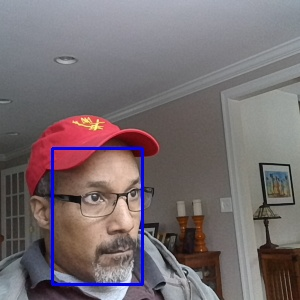

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Stop the Video')

In [9]:
# define the button widget
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop the Video',
    icon='square'
)

# initialize the display window
display_handle=display(None, display_id=True)
# display the stop button
display(stopButton)
# create a thread that calls the showVideo() function above
thread = threading.Thread(target=showVideo, args=(stopButton,))
thread.start()